## Detecting time series anomalies

In [1]:
#Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from env import get_connection

### Read in the data from Codeup SQL server

In [2]:
#Define query
query = '''
        SELECT *
        FROM logs
        '''

In [3]:
#Define url
url = get_connection('curriculum_logs')

In [4]:
#Read data from SQL server
df = pd.read_sql(query, url)
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [5]:
#Cache
df.to_csv('curriculum_logs.csv')

**So far we have been able to to acquire the data from our sql server andf load it up to our notebook**

### pd.to_what?

In [6]:
#Change date to datetime object
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.dtypes

date         datetime64[ns]
time                 object
path                 object
user_id               int64
cohort_id           float64
ip                   object
dtype: object

In [7]:
#Set as index
df = df.set_index('date')
df.head()

,time,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [8]:
#Resample the data by day and count the number of hits each day
daily_hits = df['path'].resample('d').count()
daily_hits.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

### Exponential moving average

Simple moving average has a lag associated with it

Exponential moving average minimizes the lag by weighting recent points more heavily

We will use the pandas ewm (Exponential Weighted Calculations) method to assist us

We will have to define the span argument for how many observations we will include in the calculation. We will try a few different spans to see how it affects the smoothness of the moving average

In [9]:
#Define weekly average with span=7
weekly_avg = daily_hits.ewm(span=7).mean()
weekly_avg.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: path, dtype: float64

In [10]:
#Define monthly average
monthly_avg = daily_hits.ewm(span=30).mean()
monthly_avg.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [11]:
#Define quarterly average
quarterly_avg = daily_hits.ewm(span=90).mean()
quarterly_avg.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: path, dtype: float64

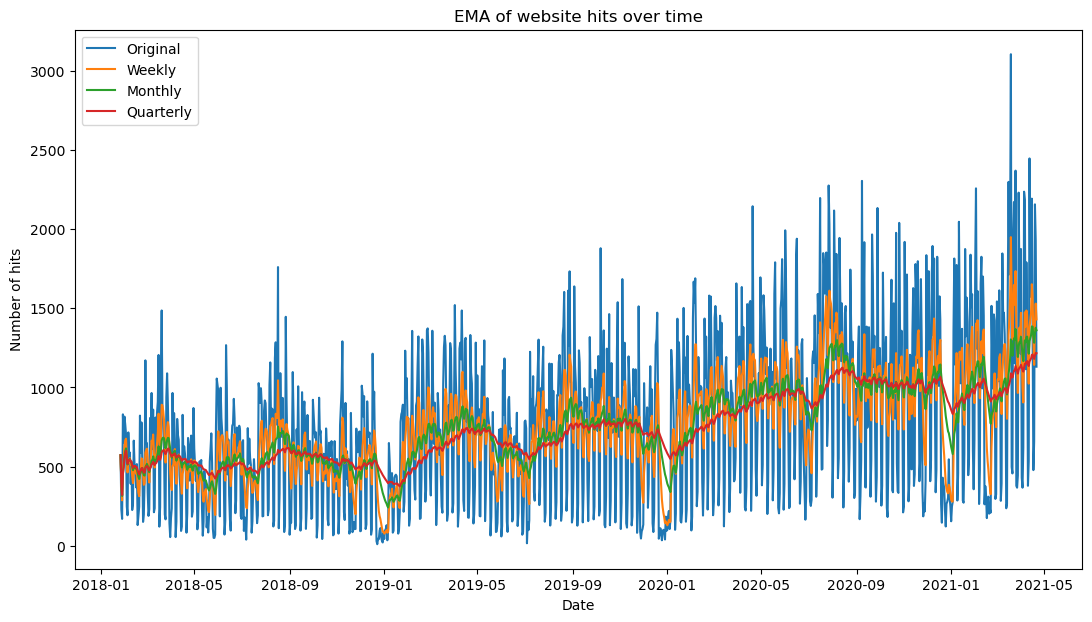

In [41]:
#Plot the exponential moving averages to see effects
'''
This graph shows the daily hits, upper band, lower band, and the midband of the number of hits
through the entire dataset using exponential moving average
'''
plt.figure(figsize=(13, 7))
plt.plot(daily_hits, label='Original')
plt.plot(weekly_avg, label='Weekly')
plt.plot(monthly_avg, label='Monthly')
plt.plot(quarterly_avg, label='Quarterly')
plt.xlabel('Date')
plt.ylabel('Number of hits')
plt.title('EMA of website hits over time')
plt.legend()
plt.show()

### Bollinger Bands

Bollinger bands are used to indicate volatility in price over time, often used to detect 100-baggers in the stock market

Bollinger bands have three parts: lower band, upper band, and midband

The midband is the exponential moving average for a defined period

The upper and lower bands are calculated using the following formula:  
Midband +/- Standard Deviation * K

In [13]:
#We have our midband already!
monthly_avg.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [14]:
#Compute exponential weighted standard deviation
monthly_std = daily_hits.ewm(span=30).std()
monthly_std.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: path, dtype: float64

In [15]:
#Compute upper and lower bands
upper_band = monthly_avg + monthly_std * 1.5
lower_band = monthly_avg - monthly_std * 1.5

In [16]:
#Create final df
final_df = pd.concat([daily_hits, monthly_avg, upper_band, lower_band], axis=1)
final_df.head()

,path,path,path,path
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221
2018-01-28,170,315.139578,635.956785,-5.677629
2018-01-29,830,457.002386,931.704142,-17.699369
2018-01-30,652,501.369064,928.088655,74.649474


In [17]:
#Rename columns
final_df.columns = ['hits', 'midband', 'upper_band', 'lower_band']
final_df.head()

,hits,midband,upper_band,lower_band
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221
2018-01-28,170,315.139578,635.956785,-5.677629
2018-01-29,830,457.002386,931.704142,-17.699369
2018-01-30,652,501.369064,928.088655,74.649474


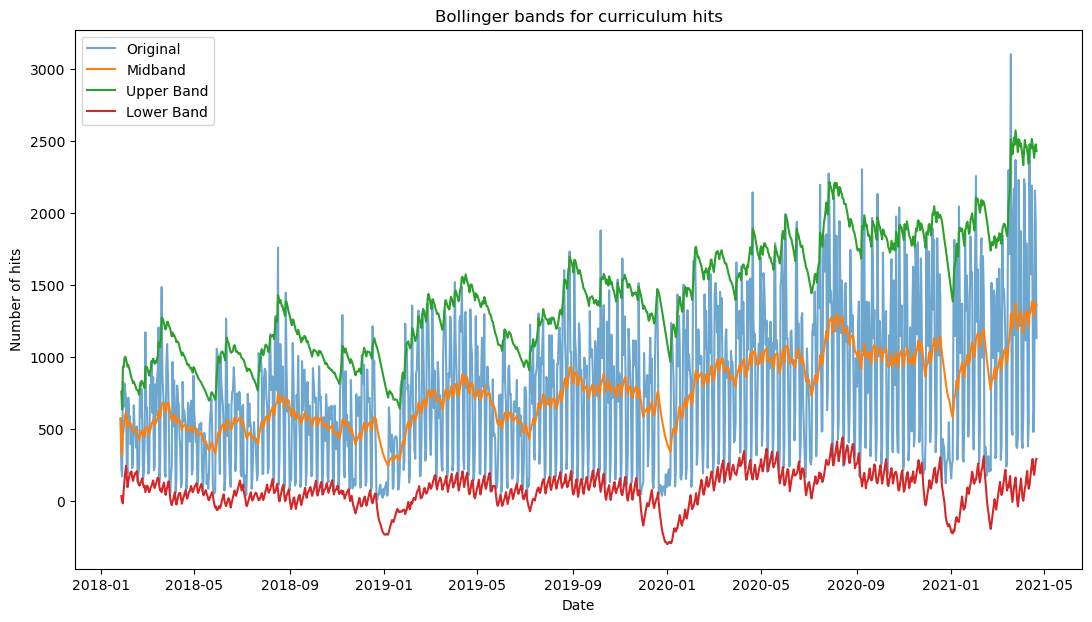

In [26]:
#Plot the bands
'''
This graph shows the daily hits, upper band, lower band, and the midband of the number of hits
through the entire dataset using 'Bollinger bands'
'''
plt.figure(figsize=(13, 7))
plt.plot(final_df['hits'], label='Original', alpha = .65)
plt.plot(final_df['midband'], label='Midband')
plt.plot(final_df['upper_band'], label='Upper Band')
plt.plot(final_df['lower_band'], label='Lower Band')
plt.xlabel('Date')
plt.ylabel('Number of hits')
plt.title('Bollinger bands for curriculum hits')
plt.legend()
plt.show()

### %b

The %b defines where a value lays relative to the bands

The formula for %b is: (last - Lower Band) / (Upper Band - Lower Band)

A value greater than 1 lies above the Upper Band, and a value less than 0 lies below the Lower Band

In [27]:
final_df.head()

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221,0.272154
2018-01-28,170,315.139578,635.956785,-5.677629,0.273797
2018-01-29,830,457.002386,931.704142,-17.699369,0.892876
2018-01-30,652,501.369064,928.088655,74.649474,0.676499


In [28]:
#Try the formula with our df
(final_df['hits'] - final_df['lower_band']) / (final_df['upper_band'] - final_df['lower_band'])

date
2018-01-26         NaN
2018-01-27    0.272154
2018-01-28    0.273797
2018-01-29    0.892876
2018-01-30    0.676499
                ...   
2021-04-17    0.118394
2021-04-18    0.217310
2021-04-19    0.866464
2021-04-20    0.751201
2021-04-21    0.392491
Freq: D, Length: 1182, dtype: float64

In [29]:
#Make new column for %b in df
final_df['pct_b'] = (final_df['hits'] - final_df['lower_band']) / (final_df['upper_band'] - final_df['lower_band'])
final_df.head()

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221,0.272154
2018-01-28,170,315.139578,635.956785,-5.677629,0.273797
2018-01-29,830,457.002386,931.704142,-17.699369,0.892876
2018-01-30,652,501.369064,928.088655,74.649474,0.676499


In [30]:
#Check for anomalies on the high side
final_df[final_df['pct_b'] > 1].sort_values('pct_b', ascending=False).head()

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2018-02-27,1171,496.375166,932.523281,60.227052,1.273390
2018-08-17,1760,751.910516,1429.611841,74.209191,1.243756
2021-03-19,3104,1303.128816,2515.100114,91.157519,1.242951
2019-01-28,1232,447.643274,988.064736,-92.778188,1.225690
2019-10-07,1879,803.738383,1545.169017,62.307748,1.225126


In [31]:
#Low side anomalies
final_df[final_df['pct_b'] < 0].sort_values('pct_b').head()

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2020-08-15,242,1205.934214,2098.302641,313.565786,-0.040099
2019-05-18,65,702.368176,1293.763070,110.973281,-0.038869
2020-09-05,168,985.144395,1746.086017,224.202772,-0.036930
2020-05-09,201,1005.779622,1755.608291,255.950954,-0.036642
2020-03-14,123,929.729604,1684.087680,175.371528,-0.034713


In [39]:
def compute_bollinger(series, column, span, k):
    
    mean_df = series.ewm(span = span).mean()
    
    std_df =series.ewm(span = span).std()
    
    upper_band = mean_df + std_df * k
    
    lower_band = mean_df - std_df * k
    
    final_df = pd.concat([series, mean_df, upper_band, lower_band], axis = 1)
    
    final_df.columns = [column, 'midband', 'ub', 'lb']
    
    final_df['pct_b'] = (final_df[column] - final_df['lb'])/ (final_df['ub'] - final_df['lb'])
    
    return final_df

In [40]:
compute_bollinger(daily_hits, 'hits', 14 , 2)

,hits,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,388.785714,872.446753,-94.875324,0.335850
2018-01-28,170,305.208829,725.773959,-115.356302,0.339253
2018-01-29,830,465.757252,1116.800959,-185.286456,0.779738
2018-01-30,652,514.347700,1087.037023,-58.341623,0.620181
...,...,...,...,...,...
2021-04-17,478,1348.173718,2797.497736,-101.150300,0.199800
2021-04-18,659,1256.283889,2690.471058,-177.903279,0.291769
2021-04-19,2156,1376.246037,2854.618836,-102.126761,0.763720
